In [23]:
%matplotlib widget
import numpy as np
import aplpy
import pyregion
#import aplpy as apl
#import matplotlib.colors as col
import matplotlib.pyplot as plt
import spectral_cube as sc
#from matplotlib.colorbar import ColorbarBase
from astropy.wcs import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import time

In [35]:
def v2ch(v, w): # convert velocity (km/s) to channel 
    x_tempo, y_tempo, v_tempo   = w.wcs_pix2world(0, 0, 0, 0)
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x_tempo, y_tempo, v*1000.0, 0)
    v_ch = int(round(float(v_ch), 0))
    return v_ch

def ch2v(ch, w):  # km/s
    x, y, v = w.wcs_pix2world(0, 0, ch, 0)
    return v / 1000.0

def new_header_v_decomp(original_hdu,max_fitted,val_type='unkown',val_unit='unkown'):
    header = original_hdu.header
    header["BTYPE"] = val_type
    header["BUNIT"] = val_unit
    #header["CTYPE1"] = val_type
    header["CUNIT3"] = val_unit
    header["NAXIS3"] = max_fitted
    header["CRVAL3"] = 1
    header["CDELT3"] = 1
    return header

def aplypy_figure(data,header_local=0,vmin=0,vmax=10,cmap='turbo',stretch='linear',save=False,save_name='',convention='wells',grid_bool=True,region_bool=True,subplot=(1,1,1),fig=[],hide_x=False,hide_y=False):
    
    try:
        if header_local == 0:
            temp_fits = fits.open('C:\\Users\\alexf\\Japan internship\C18O\\ngc1333TP.C18O.mom0.valueK.fits')
            header = temp_fits[0].header
    except TypeError:
        a=1
    
    if subplot == (1,1,1):
        fig=plt.figure()
    
    hdu = fits.PrimaryHDU(data=data,header=header_local)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    f = aplpy.FITSFigure(hdu,figure=fig,convention=convention,subplot=subplot)
    f.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch=stretch)
    f.add_colorbar()
    if grid_bool:
        f.add_grid()
        f.grid.set_color('black')
        f.grid.set_linestyle(':')
        f.grid.set_alpha(0.5)


    if hide_x:
        f.tick_labels.hide_x()
        f.axis_labels.hide_x()
        
    if hide_y:
        f.tick_labels.hide_y()
        f.axis_labels.hide_y()
        
    if region_bool:
        f.show_regions(region)

    if save:
        f.save(save_name)

    return 0

In [25]:
species = 'C18O'
file = f'C:\\Users\\alexf\Japan internship\V_decomp\\{species}\\fits_files\\3RMS\\'

region = pyregion.open('C:\\Users\\alexf\Japan internship\TP_13CO_region.reg')
current_vel_file = fits.open(file + f"{species}_Fit_Velocity.10chan.cube.fits")
current_vel_first_fit = current_vel_file[0].data[0,:,:]
current_vel_second_fit = current_vel_file[0].data[1,:,:]

model = np.load(file+'non_summed-model.npy',allow_pickle=True)
filename = f"C:\\Users\\alexf\Japan internship\\{species}\\ngc1333TP.{species}.cube.valueK.fits"
hdu = fits.open(filename)[0]
w= wcs.WCS(hdu.header)

model_first_component = model[:,:,0,:]
model_second_component = model[:,:,1,:]

In [26]:
temp_fits = fits.open('C:\\Users\\alexf\\Japan internship\C18O\\ngc1333TP.C18O.mom0.valueK.fits')
generic_header = temp_fits[0].header

0

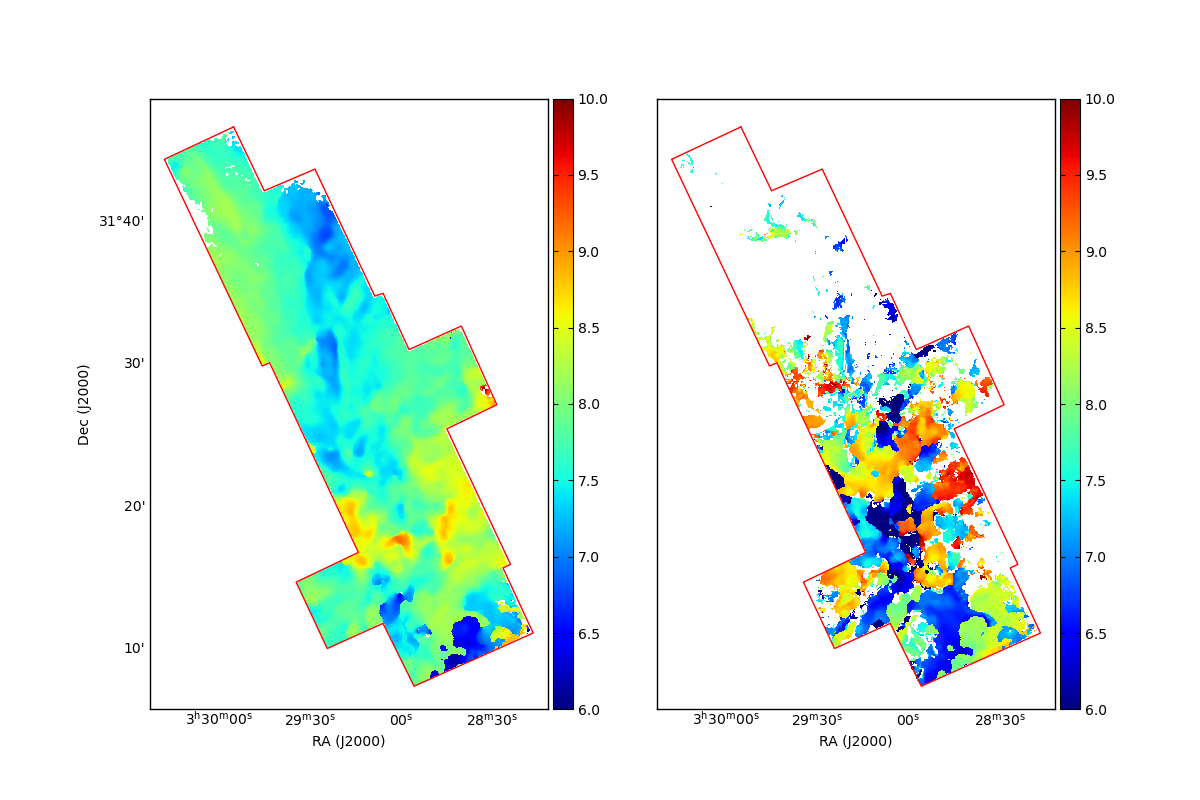

In [36]:
figure = plt.figure(figsize=(12,8))
#plt.tight_layout()
aplypy_figure(data=current_vel_first_fit,header_local=generic_header,vmin=6,vmax=10,cmap='jet',convention='',grid_bool=False,subplot=(1,2,1),fig=figure)
aplypy_figure(data=current_vel_second_fit,header_local=generic_header,vmin=6,vmax=10,cmap='jet',convention='',grid_bool=False,subplot=(1,2,2),fig=figure,hide_y=True)

In [ ]:
'''plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(current_vel_first_fit,origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(current_vel_second_fit,origin='lower',vmin=7,vmax=9)
plt.colorbar()'''

In [6]:
vel_fit_shape = np.shape(current_vel_first_fit)
l_comp = np.ones(vel_fit_shape) * np.nan
l_comp_model = np.zeros_like(model_first_component) * np.nan
d_comp = np.ones(vel_fit_shape) * np.nan
d_comp_model = np.zeros_like(model_second_component) * np.nan
single_fit_mask = np.zeros(vel_fit_shape,dtype=bool)

print(vel_fit_shape)
for i in range(vel_fit_shape[0]):
    for j in range(vel_fit_shape[1]):
        current_first_fit = current_vel_first_fit[i,j]
        current_first_model = model_first_component[i,j]
        current_second_fit = current_vel_second_fit[i,j]
        current_second_model = model_second_component[i,j]
        
        if np.isnan(current_first_fit):
            continue
        elif np.isnan(current_second_fit):
            d_comp[i,j] = current_first_fit
            d_comp_model[i,j] = current_first_model
            single_fit_mask[i,j] = True
        elif current_first_fit >= current_second_fit:
            d_comp[i,j] = current_first_fit
            d_comp_model[i,j] = current_first_model
            l_comp[i,j] = current_second_fit
            l_comp_model[i,j] = current_second_model
        elif current_first_fit <= current_second_fit:
            d_comp[i,j] = current_second_fit
            d_comp_model[i,j] = current_second_model
            l_comp[i,j] = current_first_fit
            l_comp_model[i,j] = current_first_model
            
            
multiple_fit_mask = np.logical_not(single_fit_mask)

(860, 560)


In [7]:

new_header = new_header_v_decomp(hdu,len(model_first_component[0,0]),val_type="Velocity",val_unit="km/s")


new_cube = sc.SpectralCube(data=d_comp_model,header=new_header,wcs=w)
new_cube.write(f'{species}_d_comp_model.cube.fits',format='fits',overwrite=True)

new_cube = sc.SpectralCube(data=l_comp_model,header=new_header,wcs=w)
new_cube.write(f'{species}_l_comp_model.cube.fits',format='fits',overwrite=True)

0

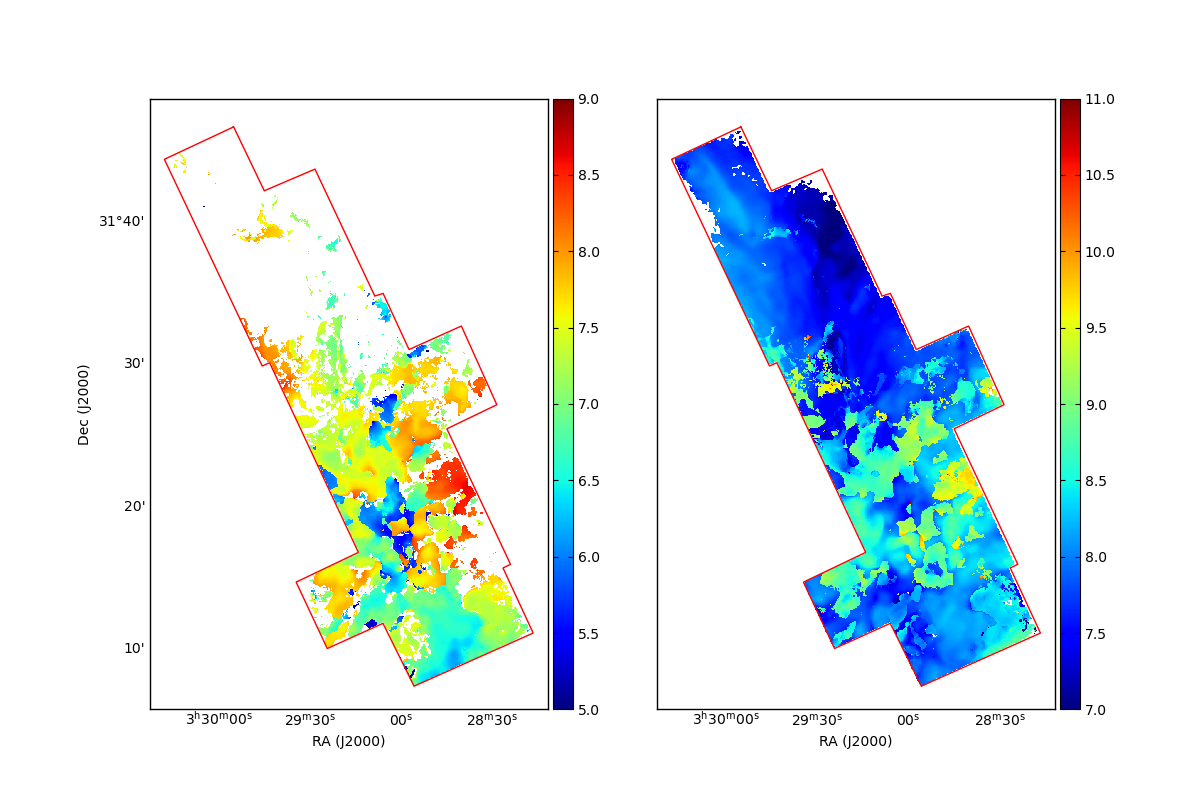

In [8]:
figure = plt.figure(figsize=(12,8))
#plt.tight_layout()
aplypy_figure(data=l_comp,header_local=generic_header,vmin=5,vmax=9,cmap='jet',stretch='log',grid_bool=False,subplot=(1,2,1),fig=figure)
aplypy_figure(data=d_comp,header_local=generic_header,vmin=7,vmax=11,cmap='jet',stretch='log',grid_bool=False,subplot=(1,2,2),fig=figure,hide_y=True)

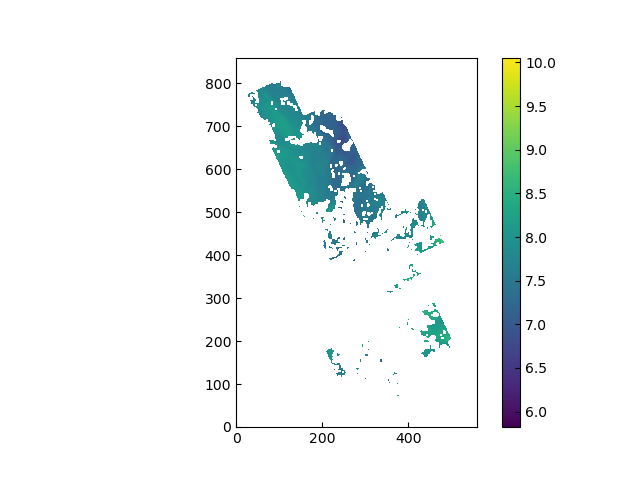

In [9]:
chan_num = '10chan'
plt.figure()
fit_count = fits.open(file+f'{species}_fit_count.{chan_num}.fits')

'''single_fit_vel = np.where(single_fit_mask,current_vel_first_fit,np.nan)


plt.imshow(single_fit_vel,origin='lower')
plt.colorbar()'''

In [ ]:
'''plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(l_comp,origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(d_comp,origin='lower')
plt.colorbar()'''

0

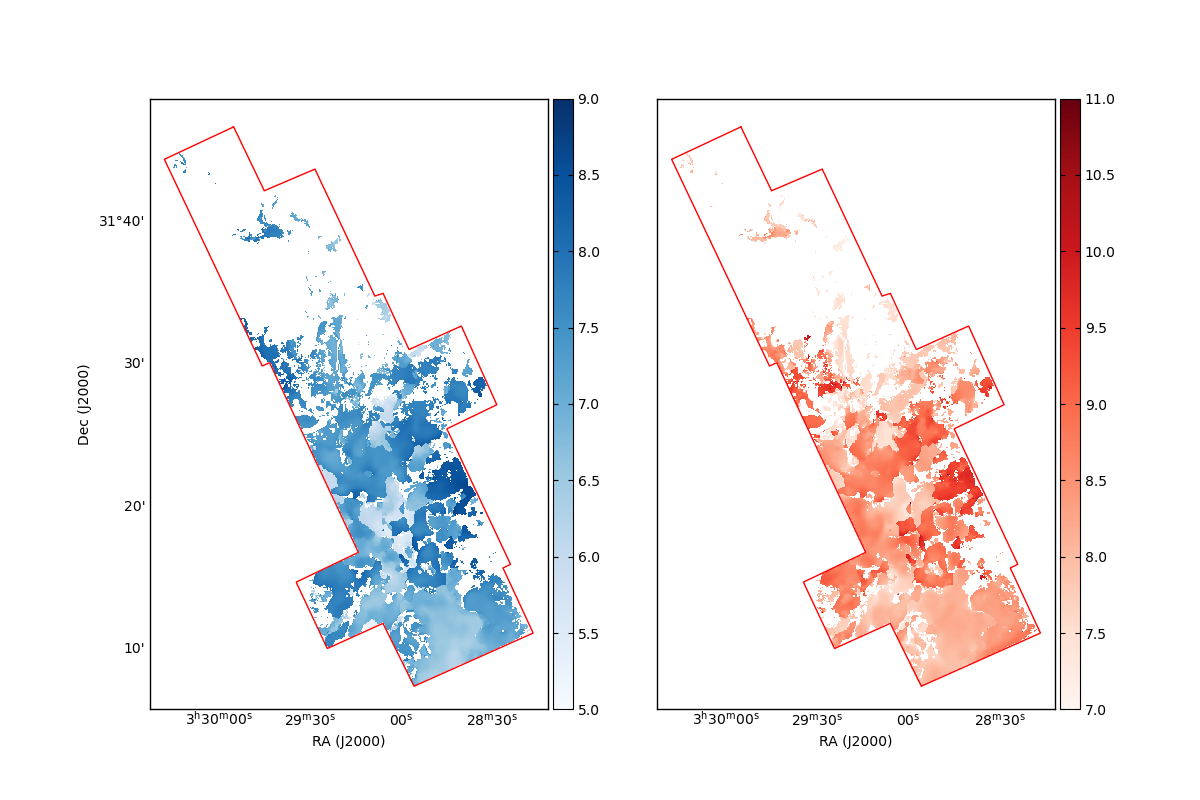

In [14]:
l_comp_multi = np.where(multiple_fit_mask==True,l_comp,np.nan)
d_comp_multi = np.where(multiple_fit_mask==True,d_comp,np.nan)

figure = plt.figure(figsize=(12,8))
#plt.tight_layout()
aplypy_figure(data=l_comp_multi,header_local=generic_header,vmin=5,vmax=9,cmap='Blues',convention='',grid_bool=False,subplot=(1,2,1),fig=figure)
aplypy_figure(data=d_comp_multi,header_local=generic_header,vmin=7,vmax=11,cmap='Reds',convention='',grid_bool=False,subplot=(1,2,2),fig=figure,hide_y=True)

In [ ]:
'''current_data = current_vel_second_fit - np.nanmean(single_fit_vel.flatten())
types = 'vel_second_fit'
chan_num = '10_chan.subtracted'
new_header = new_header_v_decomp(hdu,1,val_type="Velocity",val_unit="km/s")
fits_map = fits.PrimaryHDU(data=current_data,header=new_header)
fits_map.writeto(f'V_decomp//C18O//{species}.{types}.{chan_num}.fits',overwrite=True)
#new_cube.write(f'V_decomp//C18O//{species}.{types}.{chan_num}.fits',format='fits',overwrite=True)'''

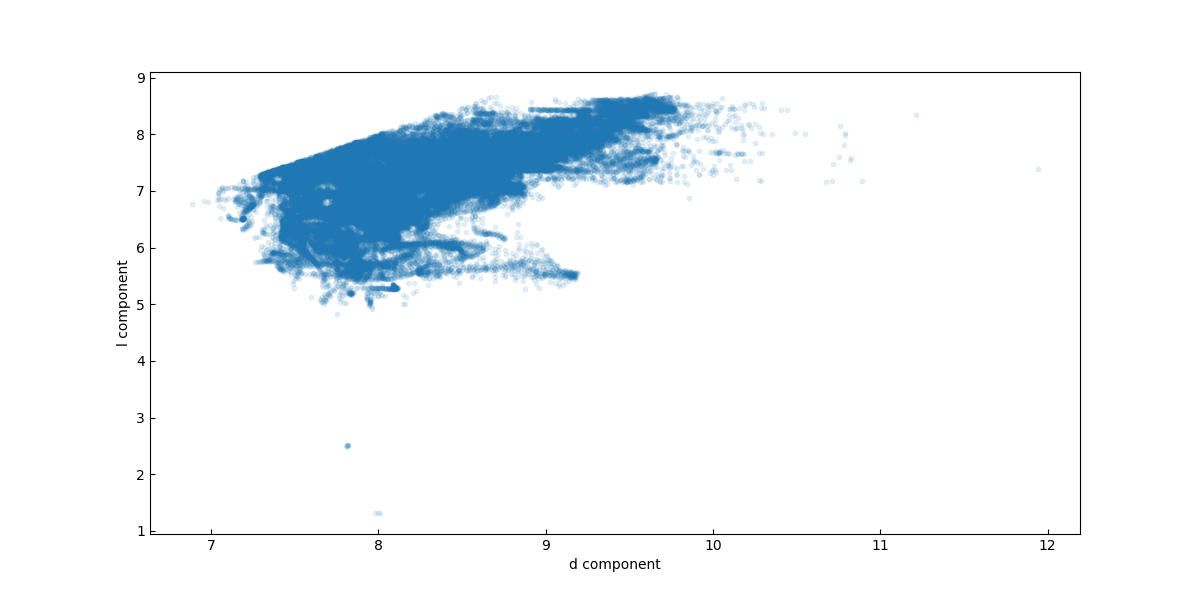

In [11]:
plt.figure(figsize=(12,6))
plt.plot(d_comp.flatten(),l_comp.flatten(),".",alpha=0.1)
plt.xlabel('d component')
plt.ylabel('l component')
plt.show()

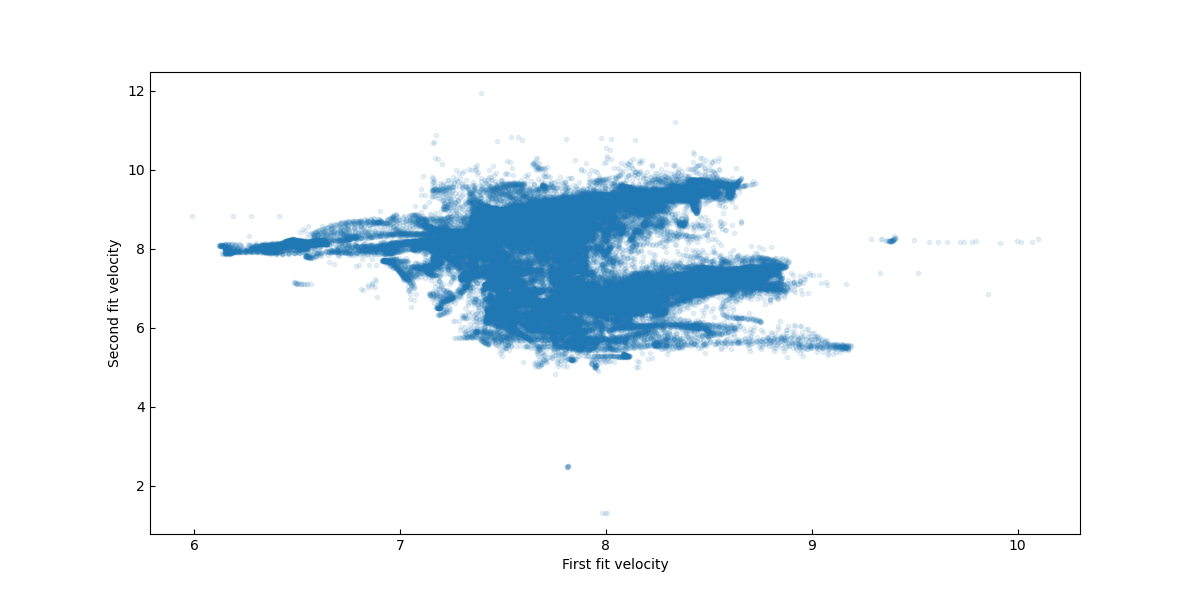

In [12]:
plt.figure(figsize=(12,6))
plt.plot(current_vel_first_fit.flatten(),current_vel_second_fit.flatten(),".",alpha=0.1)
plt.xlabel('First fit velocity')
plt.ylabel('Second fit velocity')
plt.show()

In [ ]:
#vel_mask = np.logical_and( np.logical_and(d_comp>=1,d_comp<=13) , np.logical_and(l_comp>=1,l_comp<=13))
vel_mask = np.logical_and(l_comp<=4,d_comp<=9)


plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(np.where(vel_mask==True,current_vel_first_fit,0),origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.where(vel_mask==False,current_vel_first_fit,0),origin='lower')
plt.colorbar()

In [ ]:
residuals = fits.open(file+f'{species}_residuals.{chan_num}.cube.fits')[0]
selected_residuals = residuals.data[:,309,313]

In [ ]:
y_dec = 293
x_ra = 252

model_selected = model[x_ra,y_dec,:]

sum_test = np.nansum(model_selected,axis=0)
print(np.shape(sum_test))
data_selected = hdu.data[:,x_ra,y_dec]
print(np.shape(data_selected))

channel_cont = np.arange(0,np.shape(data_selected)[0])
velocity_cont = ch2v(channel_cont, w)

In [ ]:
plt.figure()

#for i in range(np.shape(model_selected)[0]):
#    plt.plot(velocity_cont,model_selected[i],":")

'''plt.plot(velocity_cont,model_selected[0],':',alpha=0.5)
plt.plot(velocity_cont,model_selected[1],':',alpha=0.5)
#plt.plot(selected_final_model,color='green')'''

plt.plot(velocity_cont,data_selected,'b',alpha=0.7)
plt.plot(velocity_cont,sum_test,'r',alpha=0.7)
plt.plot(velocity_cont,sum_test-model_selected[0])
plt.plot(velocity_cont,sum_test-model_selected[0]-model_selected[1])
channel_max = np.nanargmax(data_selected)
print(channel_max)
print(velocity_cont[channel_max])
channel_tol = 5
velocity_current_cont = velocity_cont[channel_max - channel_tol : channel_max + channel_tol]
selected_current_slice = data_selected[channel_max - channel_tol : channel_max + channel_tol]

plt.plot(velocity_current_cont,selected_current_slice,"r.")
plt.plot(velocity_cont,selected_residuals,'g')

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(131)
l = plt.hist(l_comp.flatten(),color='red',bins=100)
plt.subplot(132)
d = plt.hist(d_comp.flatten(),color='blue',bins=100)


plt.subplot(133)
#_,bins,_ = plt.hist(l_comp.flatten(),bins=100,color='red',alpha=0.7,range=[np.nanmin(d_comp.flatten()),np.nanmax(d_comp.flatten())])
plt.hist(l_comp.flatten(),bins=100,color='red',alpha=0.7)
plt.hist(d_comp.flatten(),bins=100,color='blue',alpha=0.7)

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(131)
l = plt.hist(l_comp_multi.flatten(),color='red',bins=100)
plt.title(f"Population: {np.sum(l[0]):.0f}")
plt.subplot(132)
d = plt.hist(d_comp_multi.flatten(),color='blue',bins=100)
plt.title(f"Population: {np.sum(d[0]):.0f}")


plt.subplot(133)
#_,bins,_ = plt.hist(l_comp_multi.flatten(),bins=100,color='red',alpha=0.7,range=[np.nanmin(d_comp_multi.flatten()),np.nanmax(d_comp_multi.flatten())])
plt.hist(d_comp_multi.flatten(),bins=100,color='blue',alpha=0.7)
plt.hist(l_comp_multi.flatten(),bins=100,color='red',alpha=0.7)

plt.tight_layout()

In [ ]:
plt.figure()
plt.hist(single_fit_vel.flatten())
print(np.nanmean(single_fit_vel.flatten()))
print(np.nanmedian(single_fit_vel.flatten()))

ambient_velocity = np.nanmedian(single_fit_vel.flatten())

In [ ]:
plt.figure()
l_vel_comp_subtracted = l_comp - ambient_velocity

l_vel_comp_sub_above = np.where(l_vel_comp_subtracted>=0,l_vel_comp_subtracted,np.nan)
l_vel_comp_sub_below = np.where(l_vel_comp_subtracted<=0,l_vel_comp_subtracted,np.nan)
plt.imshow(l_vel_comp_sub_below,origin='lower',cmap='Reds')
plt.colorbar()
plt.imshow(l_vel_comp_sub_above,origin='lower',cmap='Blues')
plt.colorbar()
plt.tight_layout()

In [ ]:
plt.figure()
d_vel_comp_subtracted = d_comp - ambient_velocity

d_vel_comp_sub_above = np.where(d_vel_comp_subtracted>=0,d_vel_comp_subtracted,np.nan)
d_vel_comp_sub_below = np.where(d_vel_comp_subtracted<=0,d_vel_comp_subtracted,np.nan)
plt.imshow(d_vel_comp_sub_below,origin='lower',cmap='Reds')
plt.colorbar()
plt.imshow(d_vel_comp_sub_above,origin='lower',cmap='Blues')
plt.colorbar()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(131)
red_shifted_hist = plt.hist(l_vel_comp_sub_below.flatten() + ambient_velocity,color='red',bins=100)
plt.title(f"Population: {np.sum(l[0]):.0f}")
plt.subplot(132)
blue_shifted_hist = plt.hist(l_vel_comp_sub_above.flatten() + ambient_velocity,color='blue',bins=100)
plt.title(f"Population: {np.sum(d[0]):.0f}")


plt.subplot(133)
#_,bins,_ = plt.hist(l_comp_multi.flatten(),bins=100,color='red',alpha=0.7,range=[np.nanmin(d_comp_multi.flatten()),np.nanmax(d_comp_multi.flatten())])
plt.hist(l_vel_comp_sub_below.flatten() + ambient_velocity,bins=100,color='red',alpha=0.7)
plt.hist(l_vel_comp_sub_above.flatten() + ambient_velocity,bins=100,color='blue',alpha=0.7)

plt.tight_layout()

In [ ]:
# Find channels correspoding to above histograms
red_lower_chan = v2ch(np.min(red_shifted_hist[1]),w=w)
red_higher_chan = v2ch(np.max(red_shifted_hist[1]),w=w)
print(red_lower_chan,red_higher_chan)

blue_lower_chan = v2ch(np.min(blue_shifted_hist[1]),w=w)
blue_higher_chan = v2ch(np.max(blue_shifted_hist[1]),w=w)
print(blue_lower_chan,blue_higher_chan)

# Select second fitted component from model
l_comp_model_red = l_comp_model[:,:,red_lower_chan:red_higher_chan]
l_comp_model_blue = l_comp_model[:,:,blue_lower_chan:blue_higher_chan]

red_integrated = np.sum(l_comp_model_red,axis=2)
blue_integrated = np.sum(l_comp_model_blue,axis=2)

In [ ]:
print(np.shape(red_integrated))

In [ ]:
plt.figure()
plt.imshow(red_integrated,origin='lower',cmap='Reds',alpha=0.7)
plt.colorbar()
plt.imshow(blue_integrated,origin='lower',cmap='Blues',alpha=0.7)
plt.colorbar()

In [ ]:
current_data = blue_integrated
types = 'blue_shifted_outflows_integrated'
chan_num = '10_chan'
new_header = new_header_v_decomp(hdu,1,val_type="Velocity",val_unit="km/s")
fits_map = fits.PrimaryHDU(data=current_data,header=new_header)
fits_map.writeto(f'V_decomp//C18O//{species}.{types}.{chan_num}.fits',overwrite=True)